In [1]:
# %%
from IPython import get_ipython  # type: ignore

# %% 
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')



# %%
# Import the PyTorch modules
import torch  # type: ignore
from torch import nn  # type: ignore
from torch.optim import SGD, Adam, RMSprop  # type: ignore

# Import Tensorflow writer
from torch.utils.tensorboard import SummaryWriter  # type: ignore

# Import the giotto-deep modules
from gdeep.data import OrbitsGenerator, DataLoaderKwargs
from gdeep.topology_layers import SetTransformer, PersFormer, PytorchTransformer
from gdeep.pipeline import Pipeline
from gdeep.search import Benchmark
from gdeep.search import Gridsearch
# %%


Using GPU!
No TPUs...


In [10]:
# %%
# Define the data loader

homology_dimensions = (0, 1)

dataloaders_dicts = DataLoaderKwargs(train_kwargs = {"batch_size": 8},
                                     val_kwargs = {"batch_size": 4},
                                     test_kwargs = {"batch_size": 3})

og = OrbitsGenerator(num_orbits_per_class=1_000,
                     homology_dimensions = homology_dimensions,
                     validation_percentage=0.0,
                     test_percentage=0.0,
                     n_jobs=8
                    )

dl_train, _, _ = og.get_dataloader_persistence_diagrams(dataloaders_dicts)




In [ ]:
#model = PersFormer(
            dim_input=4,
            dim_output=5,
            n_layers=4,
            hidden_size=32,
            n_heads=4,
            dropout=0.2,
            layer_norm=True,
            pre_layer_norm=True,
            activation=nn.ReLU,
            attention_layer_type="self_attention").double()

In [109]:
class SmallDeepSet(nn.Module):
    def __init__(self, n_layer_enc=3, n_layer_dec=2, hidden_dim=64, input_dim=4, output_dim=5):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.ReLU(),
            *[nn.Sequential(
                    nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                    nn.ReLU()
                )
                for _ in range(n_layer_enc - 1)
            ]
        ).double()
        self.dec =nn.Sequential(*[
                nn.Sequential(
                    nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                    nn.ReLU()
                )
                for _ in range(n_layer_dec - 1)
            ],
            nn.Linear(in_features=hidden_dim, out_features=output_dim)).double()

    def forward(self, x):
        print(x.shape)
        x = self.enc(x)
        # max pooling
        x = x.max(dim=1)[0]
        x = self.dec(x)
        return x

In [111]:
# %%

# %%
small_model = SmallDeepSet(input_dim=2 + len(homology_dimensions), output_dim=5)

# %%
# Do training and validation

# initialise loss
loss_fn = nn.CrossEntropyLoss()

# Initialize the Tensorflow writer
writer = SummaryWriter()

# initialise pipeline class
pipe = Pipeline(small_model, [dl_train, None], loss_fn, writer)
# %%
#pipe.train(SGD, 2, True, {"lr": 0.001}, k_folds=2)

# Gridsearch

# initialise gridsearch
search = Gridsearch(pipe, search_metric="accuracy", n_trials=2)

# dictionaries of hyperparameters
optimizers_params = {"lr": [0.001, 0.01]}
dataloaders_params = {"batch_size": [32, 64, 16]}
models_hyperparams = {"n_layer_enc": [4,5],
                      "n_layer_dec": [2,3],
                      "hidden_dim": [16, 32]}

# starting the gridsearch
search.start((Adam,), n_epochs=50, cross_validation=False,
             optimizers_params=optimizers_params,
             dataloaders_params=dataloaders_params,
             models_hyperparams=models_hyperparams, lr_scheduler=None,
              scheduler_params=None)

[I 2021-11-09 20:42:09,724] A new study created in memory with name: no-name-11a1adb4-5f07-4e49-b940-523808951f47


Using GPU!
No TPUs...
Epoch 1
-------------------------------
No TPUs


[W 2021-11-09 20:42:09,910] Trial 0 failed because of the following error: AttributeError("'NoneType' object has no attribute 'zero_grad'")
Traceback (most recent call last):
  File "/home/jovyan/conda-envs/giottodeep/lib/python3.8/site-packages/optuna/_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
  File "/home/jovyan/Innosuisse/giotto-deep/gdeep/search/gridsearch.py", line 266, in <lambda>
    self.study.optimize(lambda tr: self._objective(tr,
  File "/home/jovyan/Innosuisse/giotto-deep/gdeep/search/gridsearch.py", line 128, in _objective
    loss, accuracy = new_pipe.train(optimizer, n_epochs,
  File "/home/jovyan/Innosuisse/giotto-deep/gdeep/pipeline/pipeline.py", line 475, in train
    valloss, valacc = self._training_loops(n_epochs, dl_tr,
  File "/home/jovyan/Innosuisse/giotto-deep/gdeep/pipeline/pipeline.py", line 541, in _training_loops
    self._train_loop(dl_tr, writer_tag)
  File "/home/jovyan/Innosuisse/giotto-deep/gdeep/pipeline/pipeline.py", lin

X.shape torch.Size([32, 1315, 4])
torch.Size([32, 1315, 4])


AttributeError: 'NoneType' object has no attribute 'zero_grad'

In [106]:
search.new_pipe

AttributeError: 'Gridsearch' object has no attribute 'new_pipe'

In [53]:
og = OrbitsGenerator(num_orbits_per_class=1_00,
                     homology_dimensions = homology_dimensions,
                     validation_percentage=0.0,
                     test_percentage=0.0,
                     dynamical_system = 'pp_convention',
                     n_jobs=8
                    )


In [54]:
orbits = og.get_orbits()

In [55]:
from gtda.homology import VietorisRipsPersistence
wap = VietorisRipsPersistence(
                    homology_dimensions=(0,1),
                    n_jobs=8
                    )
wap.fit_transform(orbits)

array([[[0.00000000e+00, 3.72529030e-09, 0.00000000e+00],
        [0.00000000e+00, 6.45239195e-09, 0.00000000e+00],
        [0.00000000e+00, 8.33000247e-09, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],

       [[0.00000000e+00, 3.72529030e-09, 0.00000000e+00],
        [0.00000000e+00, 6.45239195e-09, 0.00000000e+00],
        [0.00000000e+00, 8.33000247e-09, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]],

       [[0.00000000e+00, 3.72529030e-09, 0.00000000e+00],
        [0.00000000e+00, 3.72529030e-09, 0.00000000e+00],
        [0.00000000e+00, 3.72529030e-09, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [0.00000000e+00, 0.00

In [43]:
orbits.shape

(5000, 1000, 2)

In [47]:
import matplotlib.pyplot as plt

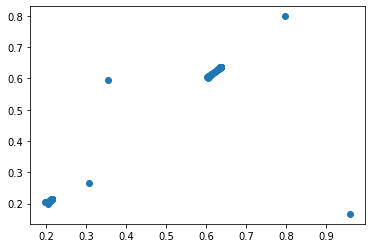

In [49]:
plt.scatter(orbits[0,:,0], orbits[0,:,1])

In [88]:
%tensorboard --logdir logs